In [1]:
import numpy as np
import pandas as pd
from pathlib import Path 
# import glob

# file_paths = glob.glob("..\data\spot_summary_*.csv")
file_paths = list(Path(__file__).parent.resolve().glob('./data/jepx/spot_summary_*.csv'))

df_spot = pd.DataFrame()
for file in file_paths:
    tmp = pd.read_csv(file, encoding='cp932')
    df_spot = pd.concat([df_spot,tmp]) 

In [2]:
df_daily_avg = df_spot.groupby("受渡日").agg({'システムプライス(円/kWh)': 'mean'})
df_daily_avg = df_daily_avg.reset_index()
df_daily_avg.columns = ['delivery_date', 'sys_price']
df_daily_avg["delivery_date"] = pd.to_datetime(df_daily_avg["delivery_date"])
df_daily_avg.loc[df_daily_avg['delivery_date'].dt.month >= 4, 'fiscal_year'] = df_daily_avg['delivery_date'].dt.year
df_daily_avg.loc[df_daily_avg['delivery_date'].dt.month < 4, 'fiscal_year'] = df_daily_avg['delivery_date'].dt.year - 1
df_daily_avg['fiscal_year'] = df_daily_avg['fiscal_year'].apply(lambda x: int(x))
df_daily_avg['year'] = df_daily_avg['delivery_date'].dt.year
df_daily_avg['month'] = df_daily_avg['delivery_date'].dt.month

ids = df_daily_avg.groupby(['year']).grouper.group_info[0]
comb = df_daily_avg.groupby(['year', 'delivery_date']).grouper.group_info[0]
count = []; nth = 0
for i, c in enumerate(comb):
    if i == 0 or ids[i] != ids[i-1]:
        nth = 1
    elif c != comb[i-1]:
        nth += 1
    count += [nth]
count

df_daily_avg['dayorder_by_year'] = count
df_daily_avg

<ipython-input-2-8836da5c4d50>:12: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  ids = df_daily_avg.groupby(['year']).grouper.group_info[0]
<ipython-input-2-8836da5c4d50>:13: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  comb = df_daily_avg.groupby(['year', 'delivery_date']).grouper.group_info[0]


,delivery_date,sys_price,fiscal_year,year,month,dayorder_by_year
0,2015-04-01,11.990208,2015,2015,4,1
1,2015-04-02,11.271667,2015,2015,4,2
2,2015-04-03,12.481458,2015,2015,4,3
3,2015-04-04,11.226667,2015,2015,4,4
4,2015-04-05,10.780833,2015,2015,4,5
...,...,...,...,...,...,...
3854,2025-10-19,10.162708,2025,2025,10,292
3855,2025-10-20,11.403542,2025,2025,10,293
3856,2025-10-21,12.662917,2025,2025,10,294
3857,2025-10-22,13.601250,2025,2025,10,295


In [3]:
df_for_reg = pd.DataFrame()

# 2019年は推定値がほぼ一致
df_temp = df_daily_avg[df_daily_avg['year']==2019].copy()
t = df_temp["dayorder_by_year"]/365.25

# 2016年～2018年は推定値が僅かにずれる
# df_temp = df_daily_avg[(df_daily_avg['year']>=2016) & (df_daily_avg['year']<2019)].copy()
# df_temp["cnt"] = range(1, len(df_temp)+1)
# t = df_temp["cnt"]/365.25

df_for_reg['y'] = df_temp['sys_price']
df_for_reg['mu'] = t
df_for_reg['s1'] = np.sin(2 * np.pi * t)
df_for_reg['s2'] = np.cos(2 * np.pi * t)
df_for_reg['s3'] = np.sin(4 * np.pi * t)
df_for_reg['s4'] = np.cos(4 * np.pi * t)
df_for_reg

,y,mu,s1,s2,s3,s4
1371,7.991458,0.002738,0.017202,0.999852,0.034398,0.999408
1372,8.172083,0.005476,0.034398,0.999408,0.068755,0.997634
1373,8.379167,0.008214,0.051584,0.998669,0.103031,0.994678
1374,8.688542,0.010951,0.068755,0.997634,0.137185,0.990545
1375,9.088750,0.013689,0.085906,0.996303,0.171177,0.985240
...,...,...,...,...,...,...
1731,7.633958,0.988364,-0.073045,0.997329,-0.145700,0.989329
1732,7.466042,0.991102,-0.055879,0.998438,-0.111583,0.993755
1733,7.258125,0.993840,-0.038696,0.999251,-0.077334,0.997005
1734,6.881458,0.996578,-0.021501,0.999769,-0.042993,0.999075


In [4]:
import statsmodels.api as sm

X = df_for_reg[df_for_reg.columns[df_for_reg.columns != 'y']]
X = sm.add_constant(X)

# 対数化
y = np.log(df_for_reg['y'])
# y = df_for_reg['y']

model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     17.70
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           1.11e-15
Time:                        16:40:46   Log-Likelihood:                 159.21
No. Observations:                 365   AIC:                            -306.4
Df Residuals:                     359   BIC:                            -283.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2124      0.031     72.534      0.000       2.152       2.272
mu            -0.1943      0.059     -3.315      0.001      -0.310      -0.079
s1            -0.0926      0.022     -4.206      0.000      -0.136      -0.049
s2             0.0314      0.012      2.690      0.007       0.008       0.054
s3             0.0588      0.015      3.937      0.000       0.029       0.088
s4             0.0250      0.012      2.137      0.033       0.002       0.048
==============================================================================
Omnibus:                       93.103   Durbin-Watson:                   0.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.489
Skew:                           1.170   Prob(JB):                     1.84e-59
Kurtosis:                       6.508   Cond. No.                         9.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
for idx in result.params.index:
    print(type(idx), idx, type(result.params[idx]), result.params[idx])

<class 'str'> const <class 'numpy.float64'> 2.212353749781696
<class 'str'> mu <class 'numpy.float64'> -0.1942791176409499
<class 'str'> s1 <class 'numpy.float64'> -0.09256067961925764
<class 'str'> s2 <class 'numpy.float64'> 0.03141673713799577
<class 'str'> s3 <class 'numpy.float64'> 0.058823754542333316
<class 'str'> s4 <class 'numpy.float64'> 0.02496082901631614


In [6]:
def curried_seasonality(params):
    def _curried_seasonality(t):
        s0 = params["const"]
        mu    =   params["mu"]
        s1    =   params["s1"]
        s2    =   params["s2"]
        s3    =   params["s3"]
        s4    =   params["s4"]

        return s0 + mu * (t/365.25) + s1 * np.sin(2 * np.pi * (t/365.25)) \
                                    + s2 * np.cos(2 * np.pi * (t/365.25)) \
                                    + s3 * np.sin(4 * np.pi * (t/365.25)) \
                                    + s4 * np.cos(4 * np.pi * (t/365.25))
    return _curried_seasonality

In [7]:
df_for_reg["t"] = range(1, len(df_for_reg)+1)
df_for_reg['calculated_seasonality'] = df_for_reg['t'].apply(curried_seasonality(result.params))
df_for_reg['Xt_log'] = np.log(df_for_reg['y'])-df_for_reg['calculated_seasonality']
df_for_reg

,y,mu,s1,s2,s3,s4,t,calculated_seasonality,Xt_log
1371,7.991458,0.002738,0.017202,0.999852,0.034398,0.999408,1,2.268611,-0.190238
1372,8.172083,0.005476,0.034398,0.999408,0.068755,0.997634,2,2.268450,-0.167727
1373,8.379167,0.008214,0.051584,0.998669,0.103031,0.994678,3,2.268247,-0.142498
1374,8.688542,0.010951,0.068755,0.997634,0.137185,0.990545,4,2.267999,-0.105994
1375,9.088750,0.013689,0.085906,0.996303,0.171177,0.985240,5,2.267705,-0.060668
...,...,...,...,...,...,...,...,...,...
1731,7.633958,0.988364,-0.073045,0.997329,-0.145700,0.989329,361,2.074553,-0.041947
1732,7.466042,0.991102,-0.055879,0.998438,-0.111583,0.993755,362,2.074584,-0.064219
1733,7.258125,0.993840,-0.038696,0.999251,-0.077334,0.997005,363,2.074583,-0.092462
1734,6.881458,0.996578,-0.021501,0.999769,-0.042993,0.999075,364,2.074548,-0.145717


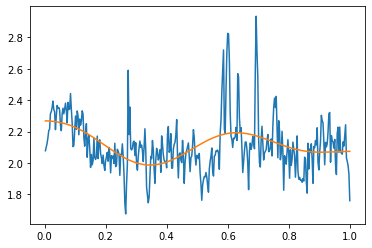

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

x = df_for_reg["t"]/365.25
y = np.log(df_for_reg["y"])
ax.plot(x, y)
ax.plot(x, df_for_reg["calculated_seasonality"])
# ax.plot(x, df_for_reg["Xt_log"])
plt.show()

In [9]:
result.params

const    2.212354
mu      -0.194279
s1      -0.092561
s2       0.031417
s3       0.058824
s4       0.024961
dtype: float64